In [ ]:
# !pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata --quiet
# !pip3 install torch torchaudio torchvision torchtext torchdata --quiet
# !pip3 install torchdiffeq --quiet
# !pip3 install torchdyn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00


# Planar Flow
## Mount Google drive 
- This notebook run in [Colab](https://colab.research.google.com/), therefore, we have to mount the google drive to store our model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import packages
- `torchdiffeq`: A module provides the ODESolver based on `torch` and implements the adjoint method mentioned in the paper by Chen et al. The functions `odeint` and `odeint_adjoint` are the ODESolvers.
- `torchdyn`: Provide the toy dataset generators.
- `progressbar`: Visualizing the process of training.

In [3]:
import torch
from torch import nn, optim, tensor, Tensor
from torchdiffeq import odeint, odeint_adjoint
from torchdyn.datasets import ToyDataset
import matplotlib.pyplot as plt
from matplotlib import animation
import progressbar
import pandas as pd

- Specify the path to the folder where we want to store our training results. Check if this folder exists.

In [7]:
import os
p2drive = './drive/MyDrive/Colab Notebooks/'
os.path.isdir(p2drive)

False

- Define a function used to store our model at checkpoint.
  - The `epoch` here actually refers to the iteration number.
  - The `model_state_dict` store the parameters be trained in the model.
  - The `optimizer_state_dict` store the parameters in the opimizer.
  - The `loss` stores the loss value at each iteration, allowing us to monitor if the loss decreases during training.

In [8]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
def save_checkpoint(func:nn.Module, EPOCH,optimizer, LOSS, PATH=os.path.join(p2drive,"six-gaussians.pt")):
  torch.save({
            'epoch': EPOCH,
            'model_state_dict': func.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [5]:
def autograd_trace(x_out, x_in):
    """
    `autograd_trace`:(`x_out`, `x_in`): compute the trace of the Jacobian of `x_out` w.r.t. `x_in` using autograd.
    """
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:,i].sum(), x_in, create_graph=True)[0].contiguous()[:,i].contiguous()
    return trJ.contiguous() # return the trace of Jacobian


class Planar(nn.Module):
    """
        Construct a net according to the Planar Flow: return the params of the flows:
        u, w, b
    :params `in_out_dim`: the dimension of the input and output.
    :params `hidden_dim`: the dimension of the hidden layers.
    :params `width`: the width of the flow. (The number of parallel flows) We average each flow result finally to get the final result.
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        params = t.reshape(1,1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)
        params = params.reshape(-1)

        w = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)
        u = params[self.blocksize:2*self.blocksize].reshape(self.width, 1,self.in_out_dim)
        g = params[2*self.blocksize:3*self.blocksize].reshape(self.width, 1,self.in_out_dim)
        u = u*torch.sigmoid(g)  # for some reason, we use u*sigmoid(g) instead of u directly.

        b = params[3 * self.blocksize:].reshape(self.width,1,1)
        return [w,u,b]


class CNF(nn.Module):
    """
        `CNF`: An object of the Continuous Normalizing Flow (CNF) model.
    :params `in_out_dim`: the dimension of the input and output.
    :params `hidden_dim`: the dimension of the hidden layers.
    :params `width`: the width of the flow. (The number of parallel flows) We average each flow result finally to get the final result.
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.planar = Planar(in_out_dim, hidden_dim, width)     # Instantiate the HyperNetwork, which input time t and return the params of the flow.

    # As the odeint solver requires the input of the forward function to be (t, states), we need to pass the time t as the first argument.
    # The `states` is a tuple of the states of the system. Here, we have two states: z and logp_z.
    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]     # get the batch size

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            w,u,b = self.planar(t)                              # get the params of the flow
            Z = torch.unsqueeze(z,0).repeat(self.width, 1,1)    # repeat the input z to match the width of the flow
            h = torch.tanh(torch.matmul(Z,w) + b)               # compute the hidden state h
            dz_dt = torch.matmul(h, u).mean(0)                  # compute the dz/dt
            dlogp_z_dt = -autograd_trace(dz_dt, z).view(batchsize, 1) # compute the dlogp_z/dt

        return (dz_dt, dlogp_z_dt)

# Train for six-gaussians datasets


In [31]:
# define the get_batch function, which returns a batch of data points.
def get_batch(num_samples):
    points, _ = ToyDataset().generate(num_samples // 6,
                              'gaussians',
                              n_gaussians=6,
                              std_gaussians=.5,
                              radius=4,dim=2)

    X = ((points - points.mean()) / points.std()).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(X.size(0), 1).type(torch.float32).to(device)
    return (X,logp_diff_t1)



- show the target distribution we want to generate.

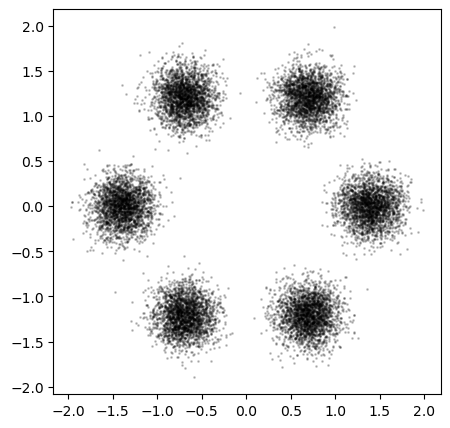

In [36]:
X, _ = get_batch(15000)
plt.figure(figsize=(5, 5))
plt.scatter(*X.detach().cpu().T, c='black', alpha=0.2, s=1.)
plt.show()

In [25]:
os.path.isdir(os.path.join(p2drive, 'six-gaussians')) or os.makedirs(os.path.join(p2drive, 'six-gaussians'))

NameError: name 'os' is not defined

In [38]:
# specify the initial time and the final time
t0 = 0
t1 = 10

func = CNF(in_out_dim=2, hidden_dim=64, width=3).to(device) # instantiate the CNF model
optimizer = optim.Adam(func.parameters(), lr=0.01)          # instantiate the optimizer

# p_z0 is the standard normal distirbution.
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)


# initialize the dataframe to store the itration and loss.
df = pd.DataFrame(columns=["itr", "loss"])


In [ ]:
for itr in progressbar.progressbar(range(1, 5000+1)):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(5000)
    z_t, logp_diff_t = odeint(
                func,
                (x, logp_diff_t1),
                torch.tensor([t1, t0]).type(torch.float32).to(device),
                atol=1e-5,
                rtol=1e-5,
                method='dopri5',
            )
    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

    # calcuate the loss
    C = 1/2 * z_t0.norm(dim=1,p=2) ** 2 + logp_diff_t0.view(-1) + torch.log(Tensor([2 * torch.pi]).to(device))
    loss = C.mean(0)


    loss.backward()
    optimizer.step()
    df.loc[len(df.index)] = [itr, loss.item()]

    # when the iterations could be divided by 100, we save the model and the loss to the disk.
    if itr % 100 == 0:
      save_checkpoint(func, itr, optimizer, loss.item(), PATH=os.path.join(p2drive,"six-gaussians","six-gaussians{}.pt".format(itr)))
      df.to_csv(os.path.join(p2drive,"six-gaussians","output_{}.csv".format(itr)))
      df = pd.DataFrame(columns=["itr", "loss"])


 23% (1150 of 5000) |####                | Elapsed Time: 0:27:35 ETA:   1:34:54

KeyboardInterrupt: 

# Train for moons datasets

In [39]:
def get_batch(num_samples):
    points, _ = ToyDataset().generate(
        n_samples=num_samples,
        noise=2e-1,
        dataset_type='moons')

    X = ((points - points.mean()) / points.std()).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(X.size(0), 1).type(torch.float32).to(device)

    return (X,logp_diff_t1)


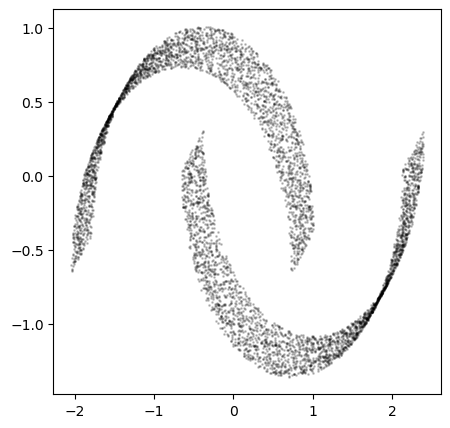

In [43]:
X, _ = get_batch(6000)
plt.figure(figsize=(5, 5))
plt.scatter(*X.detach().cpu().T, c='black', alpha=0.2, s=1.)
plt.show()

In [ ]:
os.path.isdir(os.path.join(p2drive, 'moons')) or os.makedirs(os.path.join(p2drive, 'moons'))

True

In [ ]:
# specify the initial time and the final time
t0 = 0
t1 = 10

func = CNF(in_out_dim=2, hidden_dim=64, width=3).to(device)
optimizer = optim.Adam(func.parameters(), lr=5e-3)
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)


df = pd.DataFrame(columns=["itr", "loss"])

In [ ]:
checkpoint = torch.load(os.path.join(p2drive,'moons', 'moons9900.pt'), map_location=device)
checkpoint["loss"]
func.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
func.eval()

CNF(
  (planar): Planar(
    (fc1): Linear(in_features=1, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=21, bias=True)
  )
)

In [ ]:
for itr in progressbar.progressbar(range(checkpoint['epoch']+1, checkpoint['epoch'] + 2000 + 1)):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(5000)
    z_t, logp_diff_t = odeint(
                func,
                (x, logp_diff_t1),
                torch.tensor([t1, t0]).type(torch.float32).to(device),
                atol=1e-5,
                rtol=1e-5,
                method='dopri5',
            )
    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

    # logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
    # loss = -logp_x.mean(0)
    C = 1/2 * z_t0.norm(dim=1,p=2) ** 2 + logp_diff_t0.view(-1) + torch.log(Tensor([2 * torch.pi]).to(device))
    loss = C.mean(0)


    loss.backward()
    optimizer.step()
    df.loc[len(df.index)] = [itr, loss.item()]

    if itr % 100 == 0:
      save_checkpoint(func, itr, optimizer, loss.item(), PATH=os.path.join(p2drive,"moons","moons{}.pt".format(itr)))
      df.to_csv(os.path.join(p2drive,"moons","output_{}.csv".format(itr)))
      df = pd.DataFrame(columns=["itr", "loss"])



100% (2000 of 2000) |####################| Elapsed Time: 1:39:42 Time:  1:39:42


# Sphere

In [ ]:
os.path.isdir(os.path.join(p2drive, 'spheres')) or os.makedirs(os.path.join(p2drive, 'spheres'))

In [2]:
def get_batch(num_samples):
    points, _ = ToyDataset().generate(
        n_samples=num_samples,
        noise=8e-2,
        dataset_type='spheres', dim=2)

    X = ((points - points.mean()) / points.std()).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(X.size(0), 1).type(torch.float32).to(device)

    return (X,logp_diff_t1)


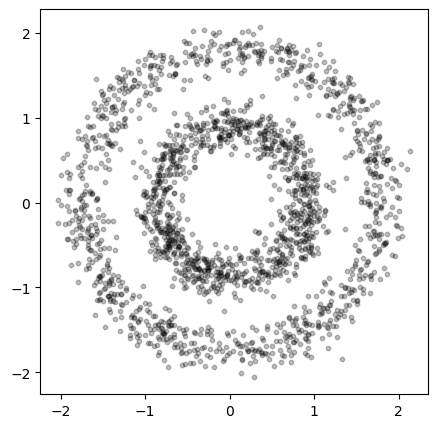

In [10]:
X, _ = get_batch(2000)
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c='black', alpha=0.25, s=10.)

In [ ]:
t0 = 0
t1 = 10

func = CNF(in_out_dim=2, hidden_dim=64, width=3).to(device)
optimizer = optim.Adam(func.parameters(), lr=5e-3)
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)


df = pd.DataFrame(columns=["itr", "loss"])

In [ ]:
checkpoint = torch.load(os.path.join(p2drive,'spheres', 'spheres2600.pt'), map_location=device)
checkpoint["loss"]
func.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
func.eval()

CNF(
  (planar): Planar(
    (fc1): Linear(in_features=1, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=21, bias=True)
  )
)

In [ ]:
for itr in progressbar.progressbar(range(checkpoint['epoch']+1, checkpoint['epoch'] + 5000 + 1)):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(50000)
    z_t, logp_diff_t = odeint(
                func,
                (x, logp_diff_t1),
                torch.tensor([t1, t0]).type(torch.float32).to(device),
                atol=1e-5,
                rtol=1e-5,
                method='dopri5',
            )
    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

    # logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
    # loss = -logp_x.mean(0)
    C = 1/2 * z_t0.norm(dim=1,p=2) ** 2 + logp_diff_t0.view(-1) + torch.log(Tensor([2 * torch.pi]).to(device))
    loss = C.mean(0)


    loss.backward()
    optimizer.step()
    df.loc[len(df.index)] = [itr, loss.item()]

    if itr % 100 == 0:
      save_checkpoint(func, itr, optimizer, loss.item(), PATH=os.path.join(p2drive,"spheres","spheres{}.pt".format(itr)))
      df.to_csv(os.path.join(p2drive,"spheres","output_{}.csv".format(itr)))
      df = pd.DataFrame(columns=["itr", "loss"])


 88% (4418 of 5000) |################   | Elapsed Time: 10:00:13 ETA:   1:40:41